acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<p/>
danceability - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<p/>
energy - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<p/>
instrumentalness - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<p/>
liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<p/>
loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
<p/>
speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<p/>
valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
<p/>
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [1]:
import pandas as pd
import numpy as np
import datetime
from math import pi, ceil

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

datapath = '../Data/'

# Import data

In [2]:
def load_playlist(playlist='saved_tracks.h5'):
    '''
    Takes in the path of the data.
    Reads the data, convertes added_at to a datetime object and extract year and month to new column.
    Also standardise the tempo to between 0 and 1.
    Returns a dataframe.
    '''
    
#     read data
    df_playlist = pd.read_hdf(datapath + playlist, key='df')
    df_playlist.drop(['analysis_url', 'track_href', 'uri', 'type'], axis=1, inplace=True)
    
#     convert to datetime, extrated year and month from added_at
    df_playlist['added_at'] = df_playlist['added_at'].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    df_playlist['added_year'] = df_playlist['added_at'].apply(lambda x : x.year)
    df_playlist['added_month'] = df_playlist['added_at'].apply(lambda x : x.month)
    
    df_playlist['tempo_01'] = df_playlist['tempo'] / df_playlist['tempo'].max()
    
    return df_playlist

In [3]:
df_saved = load_playlist()
print(df_saved.shape)

(457, 20)


In [4]:
df_saved.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01
0,0.04020,0.690,227840,0.800,0zh94d6hzJfqznRVqeROYx,0.00000,6,0.7120,-6.064,1,0.0476,126.027,4,0.888,2015-06-30 11:32:35,Give Me Your Hand (Best Song Ever),"Andrew Goldstein,Simon Wilcox,Jordan Witzigreu...",2015,6,0.623578
0,0.02840,0.647,230107,0.566,5BcnE3bJjPkR9U3PD20S0j,0.00000,2,0.0922,-7.238,1,0.0580,135.088,4,0.522,2015-07-13 16:08:16,Take Heart,The Sam Willows,2015,7,0.668412
0,0.00683,0.600,187147,0.810,0tKcYR2II1VCQWT79i5NrW,0.21000,0,0.1550,-4.749,1,0.0479,167.880,4,0.298,2017-09-11 13:09:39,Thunder,Imagine Dragons,2017,9,0.830666
0,0.08820,0.581,211507,0.937,0UyQ9TuZ1lG6eJi4eRKDfO,0.00000,5,0.3280,-4.140,1,0.0854,153.957,4,0.603,2016-02-10 05:51:18,Good Luck (Feat Lisa Kekaula),Basement Jaxx,2016,2,0.761775
0,0.05120,0.784,309013,0.781,66i1lieIMso7ef4P7KdWcE,0.00255,6,0.2630,-6.694,0,0.0856,119.898,4,0.690,2018-09-08 02:49:39,You're the One for Me,D-Train,2018,9,0.593252


# Finding out changes in taste and preferences

In [5]:
# Filter data to songs added after 2014 and before 2019
df_grp_ym = df_saved.groupby(['added_year','added_month']).mean().reset_index()
df_grp_ym = df_grp_ym[(df_grp_ym['added_year'] > 2014) & (df_grp_ym['added_year'] < 2019)]
df_grp_ym['added_at'] = df_grp_ym.apply(lambda row: datetime.date(int(row['added_year']), int(row['added_month']), 1), axis=1)
df_grp_ym.head()

,added_year,added_month,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,tempo_01,added_at
3,2015,1,0.021433,0.643250,229706.750000,0.742000,0.001026,4.000000,0.131600,-5.847000,1.000000,0.068900,119.491250,4.0,0.628000,0.591239,2015-01-01
4,2015,2,0.343633,0.574000,202339.333333,0.575000,0.000022,7.666667,0.141200,-7.214667,0.333333,0.041833,108.213333,4.0,0.494333,0.535437,2015-02-01
5,2015,4,0.348386,0.524857,227214.142857,0.636857,0.032892,6.857143,0.121800,-6.747429,1.000000,0.037700,121.472429,4.0,0.286714,0.601042,2015-04-01
6,2015,5,0.373795,0.571000,206272.000000,0.557500,0.000000,0.000000,0.132800,-7.135500,1.000000,0.030600,134.428000,4.0,0.400500,0.665146,2015-05-01
7,2015,6,0.159285,0.615500,234052.875000,0.744375,0.003026,2.875000,0.292625,-4.877250,0.625000,0.075413,107.985750,4.0,0.456737,0.534310,2015-06-01


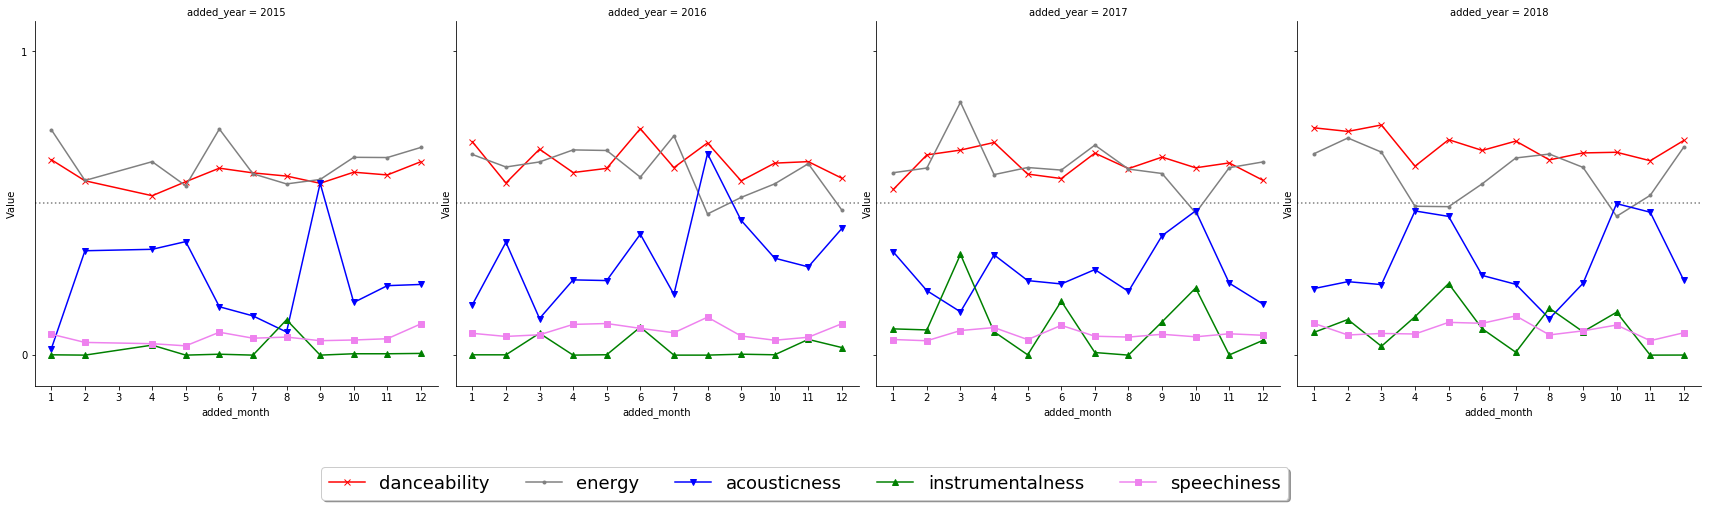

In [6]:
# sns.set(style="ticks")
grid = sns.FacetGrid(data=df_grp_ym, col="added_year", height=6, )

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0.5, ls=":", c=".5")

# Draw a line plot to show the average value per month
grid.map(plt.plot, "added_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "added_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "added_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "added_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "added_month", "speechiness", marker="s", color='violet', label='speechiness')

# Adjust the tick positions and labels
grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value')

# Adjust legend
plt.legend(loc=0, bbox_to_anchor=(0, 0, 0, -0.2), shadow=True, ncol=6, fontsize=18)



plt.show()

# Filtering out to recent songs based on taste and preferences

In [7]:
df_recent = df_saved[(df_saved['added_year'] >= 2017) & (df_saved['added_year'] < 2019)]

In [8]:
df_recent.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01
0,0.3670,0.859,190000,0.506,4t3lx9As6mqluddKju3se5,0.000024,4,0.0969,-6.070,0,0.0567,74.994,4,0.3330,2017-10-01 14:13:32,600D,Jasmine Sokko,2017,10,0.371068
0,0.3810,0.857,199440,0.800,79cuOz3SPQTuFrp8WgftAu,0.000000,2,0.0913,-4.035,1,0.0583,121.996,4,0.9660,2017-08-27 15:08:04,There's Nothing Holdin' Me Back,Shawn Mendes,2017,8,0.603633
0,0.1530,0.739,209085,0.797,4mmXeKNpOL83fu8pgAPC6s,0.000000,5,0.0617,-5.182,1,0.0644,122.979,4,0.7610,2018-07-05 14:56:40,Missing You feat. Kim Yu Na of Jaurim,G-DRAGON,2018,7,0.608497
0,0.9200,0.389,202500,0.314,64tGR2SovXarbawym7l95n,0.000742,7,0.0821,-11.051,1,0.0382,138.076,4,0.0688,2018-10-22 15:50:58,Starship,The O'My's,2018,10,0.683196
0,0.0642,0.893,223413,0.745,6BaCraQ9xeLYg4Sb9TBT2X,0.000000,11,0.0943,-3.105,0,0.0571,101.018,4,0.8720,2017-07-27 00:50:51,Feels,"Calvin Harris,Pharrell Williams,Katy Perry,Big...",2017,7,0.499834


In [9]:
df_recent.shape

(242, 20)

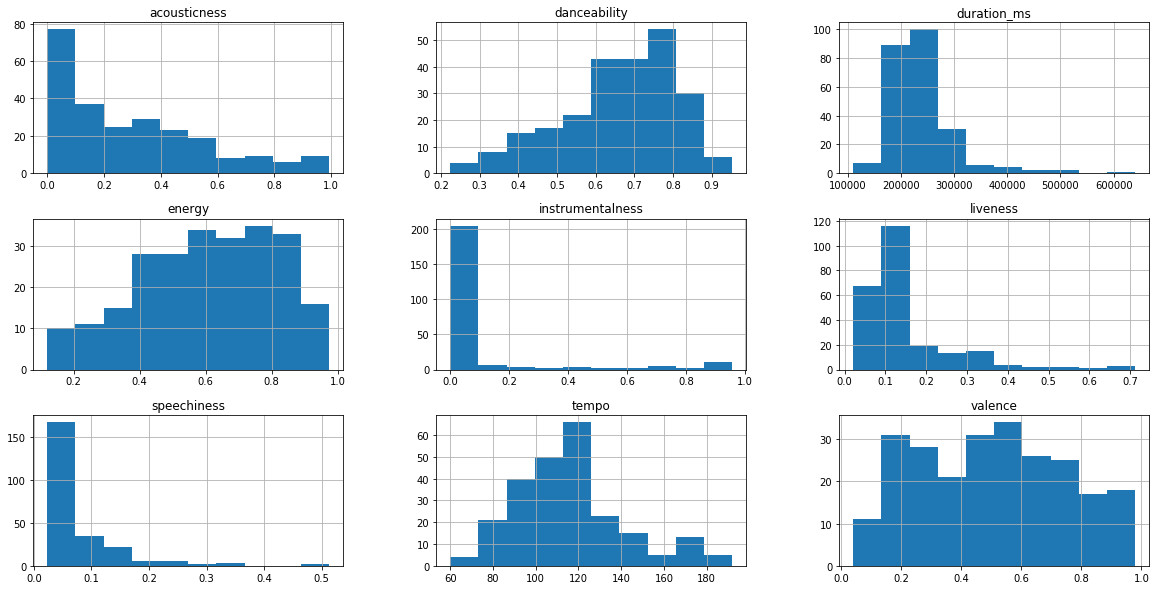

In [10]:
df_recent[['acousticness', 'danceability', 'instrumentalness', 
           'energy', 'speechiness','tempo','valence','duration_ms',
           'liveness']].hist(figsize=(20,10))
plt.show()

# Clustering similar songs together

In [11]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']
df_cluster = df_recent[cluster_features]

<Figure size 1440x1080 with 0 Axes>

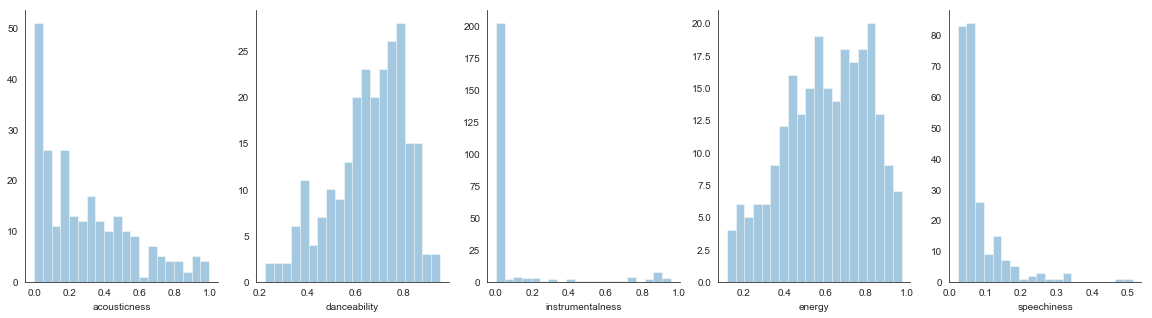

In [12]:
plt.figure(figsize=(20,15))

sns.set_style('white')
fig, axes = plt.subplots(1,5, figsize=(20,5))
for i, feature in enumerate(cluster_features):
    sns.distplot(df_cluster[feature], ax=axes[i], bins=20, kde=False)

sns.despine()
plt.show()

In [13]:
X = np.array(df_cluster)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [14]:
ss_dist = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, max_iter=10000, init='k-means++', random_state=123)
    km = km.fit(X)
    ss_dist.append(km.inertia_)

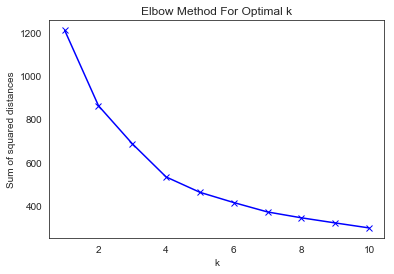

In [15]:
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
num_clusters = 5
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=10000, init='k-means++', random_state=123).fit(X)

# Visualisation of cluster using PCA

In [17]:
pca = PCA(n_components=3, random_state=123)
pca_results = pca.fit_transform(X)

In [18]:
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_.cumsum()

0.8097768707571167


array([0.39321341, 0.60975865, 0.80977687])

In [19]:
df_scree = pd.DataFrame({'Component': ['PC1','PC2','PC3'],'Indiv':pca.explained_variance_ratio_})
df_scree['cum_sum'] = df_scree['Indiv'].cumsum()
df_scree

,Component,Indiv,cum_sum
0,PC1,0.393213,0.393213
1,PC2,0.216545,0.609759
2,PC3,0.200018,0.809777


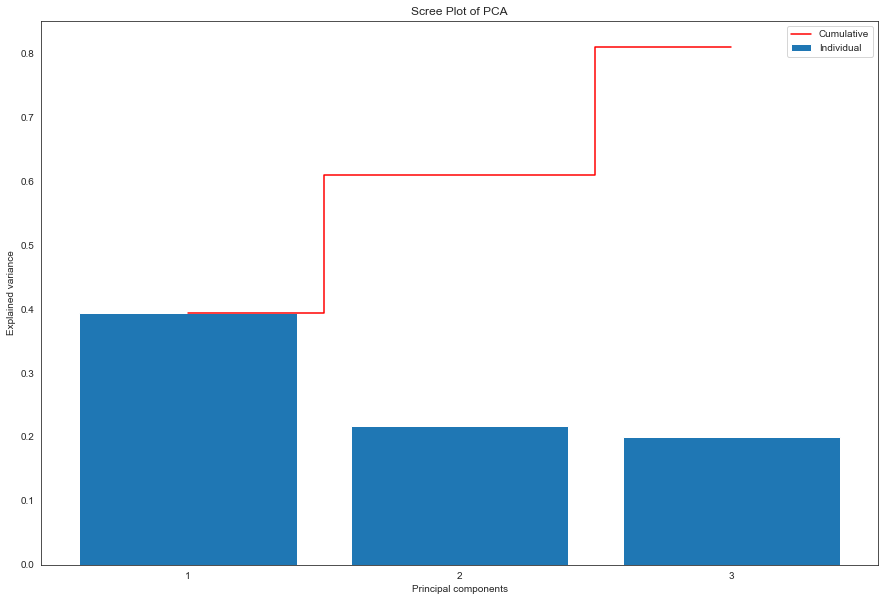

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, align='center', label='Individual', axes=ax)
plt.step(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum(), where='mid',label='Cumulative', color='r', axes=ax)

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,4))

plt.title('Scree Plot of PCA')
plt.ylabel('Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [21]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2','PC3']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,PC3,label
0,-1.612061,-0.460037,-0.165855,3
1,-0.848203,0.529288,-0.244918,3
2,-1.772555,-0.053347,0.077982,3
3,2.066736,-0.145270,-0.731940,4
4,1.253299,-0.048091,-0.444793,2


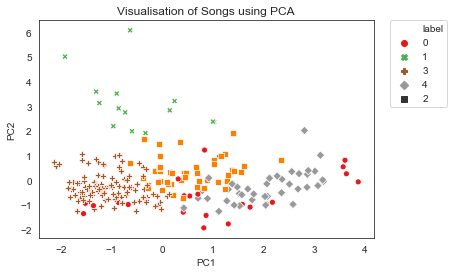

In [22]:
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs using PCA')
plt.show()

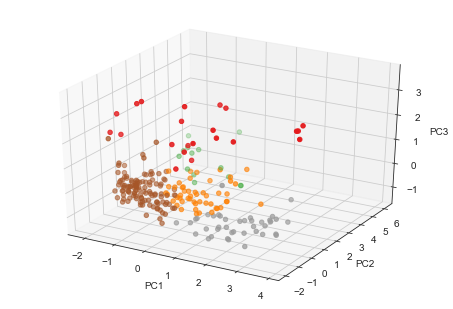

In [23]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
           c=df_pca['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

# Visualisation of clusters using TSNE

In [24]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=123, learning_rate=190)
tsne_results = tsne.fit_transform(X)

In [25]:
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['D1', 'D2']
df_tsne['label'] = kmeanModel.labels_
df_tsne.head()

,D1,D2,label
0,-1.530468,-4.553492,3
1,-5.345352,-0.751737,3
2,-3.634810,-4.158958,3
3,2.610436,7.233978,4
4,0.281340,6.819591,2


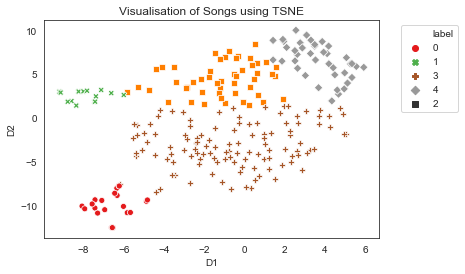

In [26]:
sns.set_style('white')
sns.scatterplot(data=df_tsne, x='D1', y='D2', hue='label', style='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Visualisation of Songs using TSNE')
plt.show()

C:\Users\john_koh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\john_koh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


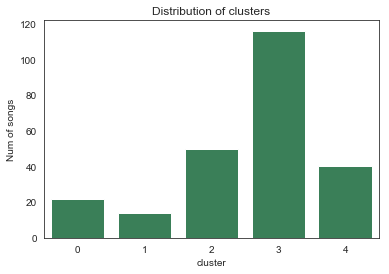

In [27]:
# assign label to recent dataframe
df_recent.loc[:,'cluster'] = kmeanModel.labels_
df_cluster_size = df_recent.groupby('cluster').size().reset_index(name='Num of songs')
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')
plt.title('Distribution of clusters')
plt.show()

# Song feature distribution compared to overall distribution

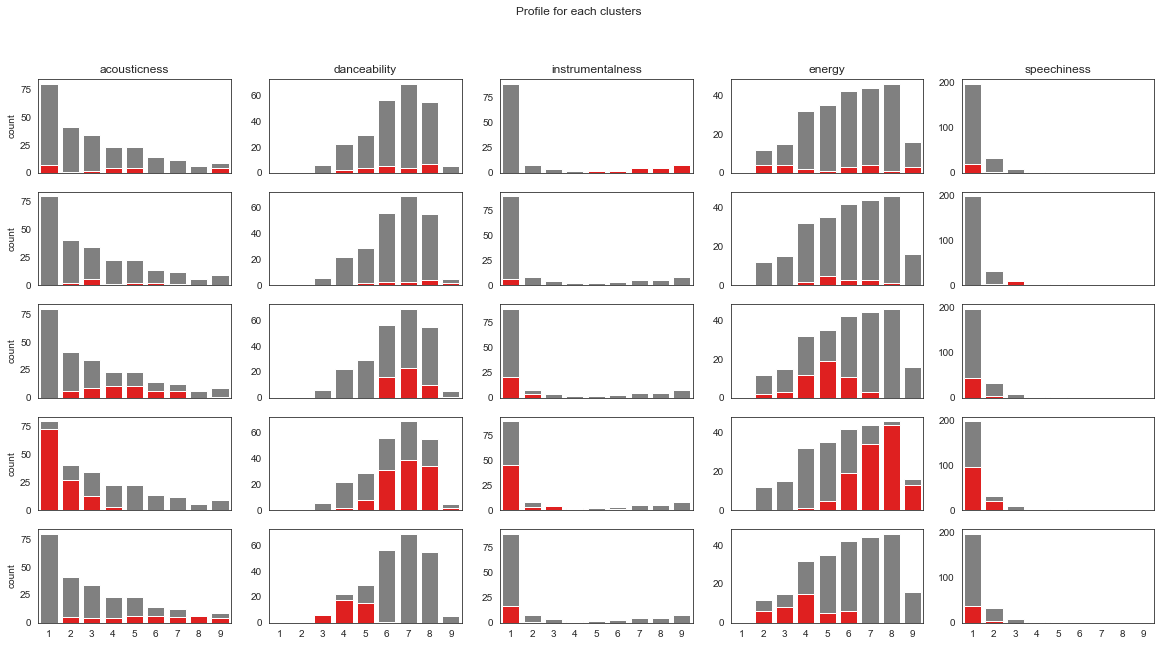

In [28]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(df_recent['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = df_recent[df_recent['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features:
#         create binned count for all recent df and clustered df
        rec_grp = df_recent.groupby(pd.cut(df_recent[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10))
        if col > 0:
            axes[row, col].set_ylabel('')
        if row == 0:
            axes[row, col].set_title(feature)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

# Average song features per cluster

In [29]:
# calculate mean of each variable
radar_col = cluster_features + ['cluster']

# feature average for each cluster as a radar chart
df_radar = df_recent[radar_col]
df_radar = df_radar.groupby('cluster').mean().reset_index()
df_radar

,cluster,acousticness,danceability,instrumentalness,energy,speechiness
0,0,0.372735,0.650500,0.792091,0.521045,0.062605
1,1,0.377500,0.736071,0.000216,0.584071,0.298214
2,2,0.452140,0.714560,0.018158,0.483360,0.064044
3,3,0.108761,0.709974,0.023676,0.755121,0.071277
4,4,0.563600,0.424800,0.015881,0.382950,0.047855


In [30]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=14, color=color, y=1.06)

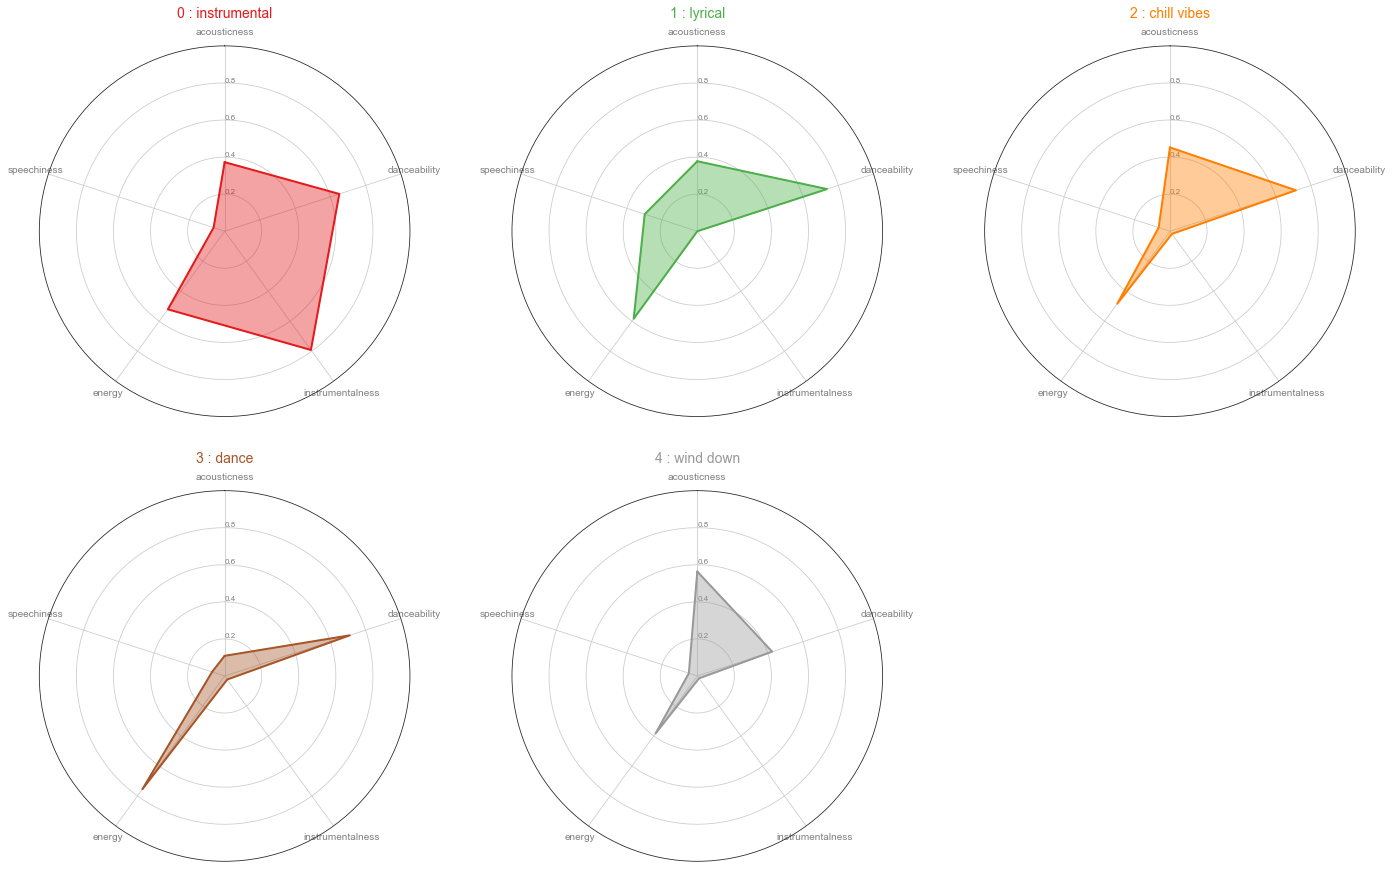

In [31]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))
 
# Loop to plot
title_list = ['instrumental', 'lyrical', 'chill vibes', 'dance', 'wind down']
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

    
# Show plot
plt.show()

# Sampling of songs in cluster

In [32]:
cluster_num = 4
df_cluster = df_recent[df_recent['cluster'] == cluster_num]
df_cluster[['song_title', 'artists']].sample(5)

,song_title,artists
0,Provide,Jereena Montemayor
0,Secrets,Jacob Lee
0,Break the Distance 2.0,Ashton Edminster
0,なんでもないや - movie ver.,RADWIMPS
0,Dear Name,IU
